In [1]:
import dask.distributed as dsk
import gcm_filters
import glob
import gsw
import intake
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xgcm import Grid
import scipy.stats as st

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import os
os.chdir('/home/561/jn8053/scripts/Dragowski')

In [3]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35353,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39461,Total threads: 1
Dashboard: /proxy/46825/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34871,


# Load data

In [ ]:
catalog = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle3'

lon_slice = slice(-230, -170)
lat_slice = slice(None, -60)

def preprocess(ds):
    ds = ds.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)
    return ds

In [7]:
diagnostic_keys = {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_river"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    }

In [8]:
ds = {}
for k in diagnostic_keys:
    ds[k] = {}
    for var in diagnostic_keys[k]:
        if k not in ["area", "maximum_depth"]:
            ds[k][var] = catalog[experiment].search(variable = var, frequency = "1mon").to_dask(
                                                    xarray_open_kwargs=dict(chunks="auto"),
                                                    preprocess=preprocess)[var]
        else:
            ds[k][var] = xr.open_dataset('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output500/ocean/ocean-2d-'+var+'.nc')[var]
        print(var+' done')

temp done
salt done
pme_river done
sfc_salt_flux_ice done
sfc_salt_flux_restore done
sfc_hflux_coupler done
sfc_hflux_from_runoff done
frazil_3d_int_z done
sfc_hflux_pme done
area_t done
ht done


In [9]:
surface_z = ds['temperature']['temp']['st_ocean'][0].item()
ds['temperature']['temp'] = ds['temperature']['temp'].isel(st_ocean=0)-273.15
ds['salinity']['salt'] = ds['salinity']['salt'].isel(st_ocean=0)

In [10]:
# Get temperature and salinity to calculate a couple other things we'll need later on
CT = ds['temperature'][diagnostic_keys['temperature'][0]].squeeze()
SP = ds['salinity'][diagnostic_keys['salinity'][0]].squeeze()
# Calculate pressure
pressure = gsw.p_from_z(-surface_z, SP['yt_ocean']).rename('pressure')
# Calculate absolute salinity
SA = gsw.SA_from_SP(SP, pressure, SP['xt_ocean'], SP['yt_ocean']).rename('SA')
# Calculate potential density
pot_rho_1 = gsw.sigma1(SA, CT).rename('pot_rho_11')

# Save everything to our dictionary
ds['pressure'] = pressure
ds['SA'] = SA
ds['pot_rho_1'] = pot_rho_1

In [11]:
# Calculate days per month accounting for leap years
months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
nyears = len(np.unique(CT['time.year']))
if CT['time.year'][0] % 4 == 0:
    days_per_month = months_standard_leap
else: 
    days_per_month = months_standard_noleap
for yr in CT['time.year'][::12][1:]:
    if yr % 4 == 0:
        days_per_month = np.concatenate([days_per_month, months_standard_leap])
    else:
        days_per_month = np.concatenate([days_per_month, months_standard_noleap])
days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
ds['days_per_month'] = days_per_month

In [ ]:
ds['pot_rho_1'].to_netcdf('/g/data/x77/jn8053/Dragowski/data/pot_rho_1_IAF.nc')
ds['days_per_month'].to_netcdf('/g/data/x77/jn8053/Dragowski/data/days_per_month_IAF.nc')

# Compute transformation

In [12]:
def compute_salt_transformation(ds):
    
    # First retrieve temperature and water_flux as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Multiply the water flux by absolute salinity to get it in the correct units
    water_flux_into_ocean = xr.Dataset(ds['water_flux_into_ocean']).to_array().squeeze().drop_vars('variable')
    water_flux_into_ocean = ds['SA'] * water_flux_into_ocean

    # Caculate the haline contraction coefficient
    haline_contraction = gsw.beta(ds['SA'], CT, ds['pressure']).rename('beta')

    # Calculate the net salt flux and multiply by 1000 to convert units
    net_salt_flux = xr.Dataset(ds['salt_flux']).to_array().sum(dim = 'variable') * 1000

    # Note that we also multiply pme_net by absolute salinity to have the correct units
    salt_transformation = haline_contraction * (water_flux_into_ocean - net_salt_flux) * ds['days_per_month']
    salt_transformation = salt_transformation.load()

    return salt_transformation

def compute_heat_transformation(ds):

    # First retrieve temperature as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Calculate the thermal expansion coefficient 
    thermal_expansion = gsw.alpha(ds['SA'], CT, ds['pressure']).rename('alpha')
    
    # Calculate the net surface heating
    net_surface_heating = xr.Dataset(ds['heat_flux']).to_array().sum(dim = 'variable')
    
    # Calculate the heat transformation
    heat_transformation = thermal_expansion * net_surface_heating * ds['days_per_month']
    heat_transformation = heat_transformation.load()

    return heat_transformation

In [13]:
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

In [14]:
salt_transformation = salt_transformation.load()
heat_transformation = heat_transformation.load()

In [15]:
salt_transformation.to_netcdf('/g/data/x77/jn8053/Dragowski/data/salt_transformation_IAF.nc')
heat_transformation.to_netcdf('/g/data/x77/jn8053/Dragowski/data/heat_transformation_IAF.nc')

# Isopycnal binning

In [16]:
salt_transformation = xr.open_dataarray('/g/data/x77/jn8053/Dragowski/data/salt_transformation_IAF.nc')
heat_transformation = xr.open_dataarray('/g/data/x77/jn8053/Dragowski/data/heat_transformation_IAF.nc')

In [17]:
ds['pot_rho_1'] = xr.open_dataarray('/g/data/x77/jn8053/Dragowski/data/pot_rho_1_IAF.nc')
ds['days_per_month'] = xr.open_dataarray('/g/data/x77/jn8053/Dragowski/data/days_per_month_IAF.nc')

In [18]:
def isopycnal_bins(pot_rho_1, days_per_month, salt_transformation, heat_transformation):
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31, 33.5, 0.02) 
    bin_bottoms = isopycnal_bins[:-1]    
    # pot_rho_1 = ds['pot_rho_1']
    X = pot_rho_1.cf['longitude']
    Y = pot_rho_1.cf['latitude']
    
    binned_salt_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'salt_transformation')

    binned_heat_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'temp_transformation')
    
    binned_salt_transformation = binned_salt_transformation.chunk({'isopycnal_bins': 1})
    binned_heat_transformation = binned_heat_transformation.chunk({'isopycnal_bins': 1})
    
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform

        masked_transform = (heat_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform

    ndays = days_per_month.sum().values
    salt_transformation = binned_salt_transformation / ndays
    
    c_p = 3992.1 # J kg-1 degC-1
    heat_transformation = binned_heat_transformation / c_p / ndays

    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1]) / 2
    salt_transformation['isopycnal_bins'] = isopycnal_bin_mid
    heat_transformation['isopycnal_bins'] = isopycnal_bin_mid
    
    # Change the sign so that positive means conversion into denser water masses
    salt_transformation = -1 * salt_transformation
    heat_transformation = -1 * heat_transformation

    return salt_transformation, heat_transformation

In [12]:
import cf_xarray as cfxr

In [20]:
for t in range(1958, 2019):
    tim_slice = slice(str(t)+'-01-01', str(t)+'-12-31')
    salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds['pot_rho_1'].sel(time=tim_slice),
                                                                            ds['days_per_month'].sel(time=tim_slice),
                                                                            salt_transformation.sel(time=tim_slice),
                                                                            heat_transformation.sel(time=tim_slice))
    salt_transformation_binned.to_netcdf('/g/data/x77/jn8053/Dragowski/data/tmp/salt_t_binned_'+str(t)+'.nc')
    heat_transformation_binned.to_netcdf('/g/data/x77/jn8053/Dragowski/data/tmp/heat_t_binned_'+str(t)+'.nc')

# Plot

In [12]:
paths_salt = np.sort(glob.glob('/g/data/x77/jn8053/Dragowski/data/tmp/salt*'))
paths_heat = np.sort(glob.glob('/g/data/x77/jn8053/Dragowski/data/tmp/heat*'))

salt_transf = xr.open_mfdataset(paths_salt, combine='nested', concat_dim='time', chunks='auto', parallel=True)['salt_transformation']
heat_transf = xr.open_mfdataset(paths_heat, combine='nested', concat_dim='time', chunks='auto', parallel=True)['temp_transformation']
net_transf = salt_transf+heat_transf

In [13]:
net_transf.load()

2025-05-27 11:57:48,209 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:42831 -> tcp://127.0.0.1:33845
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

<xarray.DataArray (time: 61, isopycnal_bins: 124, yt_ocean: 490, xt_ocean: 600)> Size: 18GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * yt_ocean        (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -60.1 -60.05
  * xt_ocean        (xt_ocean) float64 5kB -229.9 -229.8 ... -170.1 -170.0
  * isopycnal_bins  (isopycnal_bins) float64 992B 31.01 31.03 ... 33.45 33.47
Dimensions without coordinates: time

In [14]:
area = xr.open_dataset('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output500/ocean/ocean-2d-area_t.nc')['area_t']
area = area.sel(xt_ocean= net_transf['xt_ocean'], yt_ocean=net_transf['yt_ocean'])
ht = xr.open_dataset('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle3/output500/ocean/ocean-2d-ht.nc')['ht']

In [15]:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                          coords = ht.isel(yt_ocean=slice(None, 510)).coords, 
                          dims = ht.isel(yt_ocean=slice(None, 510)).dims,
                          name = 'contour_masked_above')

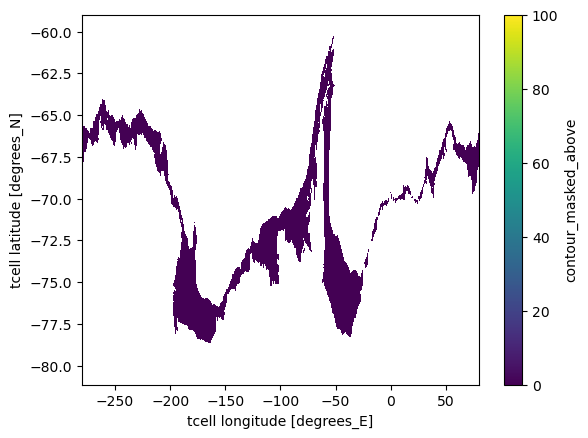

In [16]:
shelf_mask.where((shelf_mask==0)&(~np.isnan(ht))).plot(vmax=100)

In [17]:
shelf_mask = shelf_mask.where((shelf_mask==0)&(~np.isnan(ht)))

In [18]:
ht = ht.sel(xt_ocean= net_transf['xt_ocean'], yt_ocean=net_transf['yt_ocean'])

In [19]:
area = (area*(ht*0+1))

In [20]:
shelf_mask = shelf_mask.sel(xt_ocean=ht['xt_ocean'], yt_ocean=ht['yt_ocean'])

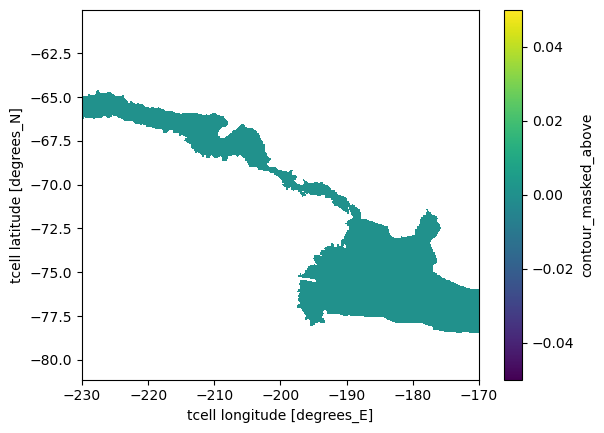

In [21]:
shelf_mask.where(shelf_mask==0).plot()

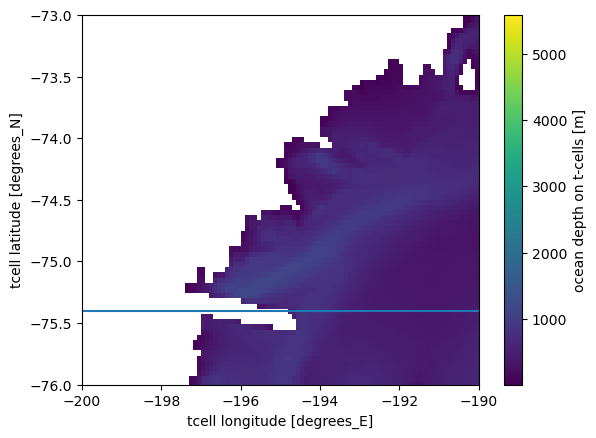

In [22]:
ht.plot(); plt.ylim(-76, -73); plt.xlim(-200, -190)
plt.axhline(y=-75.4)

In [23]:
mean_total = (1e-6*area*net_transf).where(shelf_mask==0).sel(xt_ocean=slice(-200, None)).sum(['xt_ocean', 'yt_ocean']).mean('time')
mean_drag = (1e-6*area*net_transf).where(shelf_mask==0).sel(xt_ocean=slice(-200, -190), yt_ocean=slice(-75.4, -73)).sum(['xt_ocean', 'yt_ocean']).mean('time')

In [24]:
total_max = mean_total.max().values
total_max_arg = mean_total.argmax().values

In [25]:
total_max_arg

array(78)

In [26]:
denser_than_peak = mean_total.isel(isopycnal_bins=slice(total_max_arg, None))
subset_denser_than_peak = denser_than_peak.where((denser_than_peak>.25*total_max)&((denser_than_peak<.75*total_max))).dropna('isopycnal_bins')

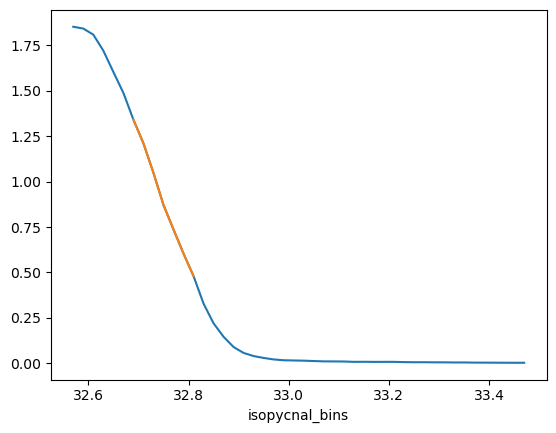

In [27]:
denser_than_peak.plot()
subset_denser_than_peak.plot()

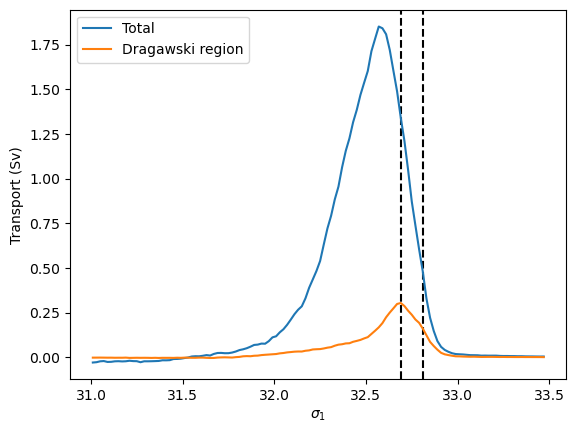

In [28]:
plt.axvline(subset_denser_than_peak['isopycnal_bins'][0], linestyle='--', color='k')
plt.axvline(subset_denser_than_peak['isopycnal_bins'][-1], linestyle='--', color='k')
mean_total.plot(label='Total')
mean_drag.plot(label='Dragawski region')
plt.legend();
plt.xlabel('$\sigma_{1}$'); plt.ylabel('Transport (Sv)');

In [29]:
mean_total.sel(isopycnal_bins=slice(subset_denser_than_peak['isopycnal_bins'][0], subset_denser_than_peak['isopycnal_bins'][-1])).mean().values

array(0.89911667)

In [30]:
mean_drag.sel(isopycnal_bins=slice(subset_denser_than_peak['isopycnal_bins'][0], subset_denser_than_peak['isopycnal_bins'][-1])).mean().values

array(0.23572957)

In [31]:
0.23572957*100/0.89911667

26.217906737286942

The Dragowski produces 26% of the SWMT of the Ross region. Let's find out over what area.

In [32]:
dsw_formation_total = net_transf.sel(isopycnal_bins=slice(subset_denser_than_peak['isopycnal_bins'][0], subset_denser_than_peak['isopycnal_bins'][-1])).mean('isopycnal_bins')

In [33]:
import cmocean as cm

Looks weird but I can't figure out why

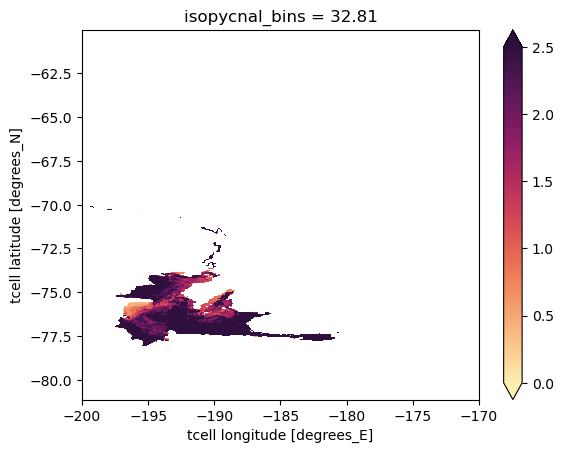

In [34]:
(1e5*net_transf.mean('time').sel(xt_ocean=slice(-200, None))).sel(isopycnal_bins=32.8, method='nearest').plot(vmin=0, vmax=2.5, cmap=cm.cm.matter)

# Time series 

In [35]:
annual_total_formation = (1e-6*area*net_transf).where(shelf_mask==0).sel(xt_ocean=slice(-200, None)).sum(['xt_ocean', 'yt_ocean'])
annual_total_formation = annual_total_formation.sel(isopycnal_bins=slice(subset_denser_than_peak['isopycnal_bins'][0], 
                                                                         subset_denser_than_peak['isopycnal_bins'][-1])).mean('isopycnal_bins')

In [36]:
annual_drag_formation = (1e-6*area*net_transf).where(shelf_mask==0).sel(xt_ocean=slice(-200, -190), yt_ocean=slice(-75.4, -73)).sum(['xt_ocean', 'yt_ocean'])
annual_drag_formation = annual_drag_formation.sel(isopycnal_bins=slice(subset_denser_than_peak['isopycnal_bins'][0], 
                                                                       subset_denser_than_peak['isopycnal_bins'][-1])).mean('isopycnal_bins')

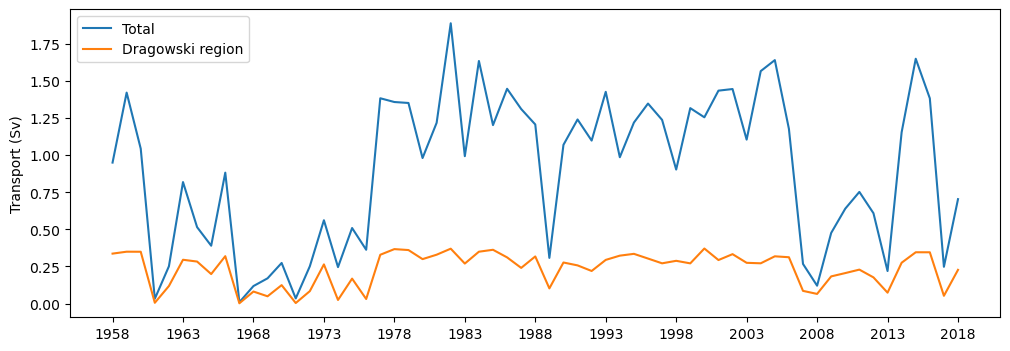

In [37]:
annual_total_formation.plot(figsize = (12,4), label = 'Total')
annual_drag_formation.plot(label = 'Dragowski region')
plt.ylabel('Transport (Sv)');
plt.xticks(np.arange(0, 61, 5), np.arange(1958, 2019, 5)); plt.legend(); plt.xlabel('');

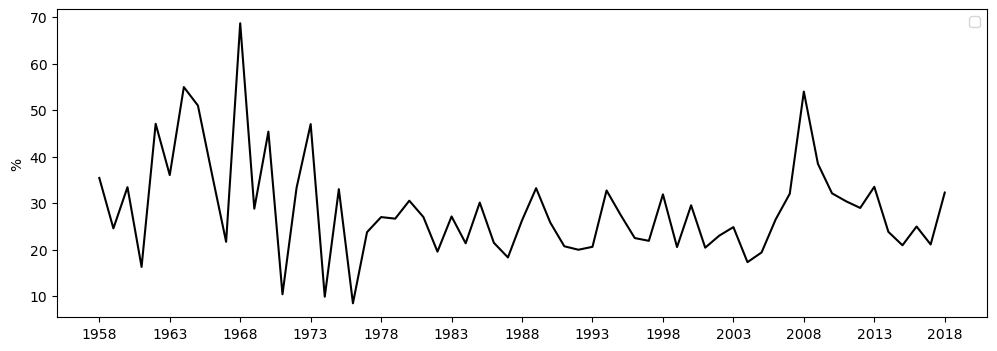

In [38]:
(annual_drag_formation/annual_total_formation*100).plot(figsize = (12,4), color='k')
plt.ylabel('%');
plt.xticks(np.arange(0, 61, 5), np.arange(1958, 2019, 5)); plt.legend(); plt.xlabel('');

Pretty cool - the Dragowski tongue produces at times up to 60% of the dense waters in the region!